# Классификация комментариев

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Задача:** обучить модель классифицировать комментарии на позитивные и негативные.

Постройть модель со значением метрики качества *F1* не меньше 0.75. 

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Загрузка" data-toc-modified-id="Загрузка-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка</a></span></li><li><span><a href="#Очистка" data-toc-modified-id="Очистка-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Очистка</a></span></li><li><span><a href="#Токенизация-и-лемматизация" data-toc-modified-id="Токенизация-и-лемматизация-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Токенизация и лемматизация</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

## Подготовка

### Загрузка

In [1]:
# загрузка библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import re

import nltk
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import (train_test_split, 
                                     RandomizedSearchCV,
                                     cross_val_score
                                    )
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

import time

RANDOM_STATE = 42

# Установка опции для отображения максимальной ширины столбца
pd.set_option('display.max_colwidth', None)

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [2]:
# загрузка дф
try:
    toxic = pd.read_csv('toxic_comments.csv')
except:
    toxic = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
# функция для просмотра общей информации о дф
def info(data):
    display(data.head())
    data.info()
    print(f'Количество дубликатов: {data.duplicated().sum()}')
    print(f'Количество пропусков: {data.isna().sum()}')

In [4]:
info(toxic)

,Unnamed: 0,text,toxic
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB
Количество дубликатов: 0
Количество пропусков: Unnamed: 0    0
text          0
toxic         0
dtype: int64


Всего 159292 уникальных комметариев пользователей, каждый из которых классифицирован на негативное и позитивное.

<AxesSubplot:xlabel='toxic', ylabel='count'>

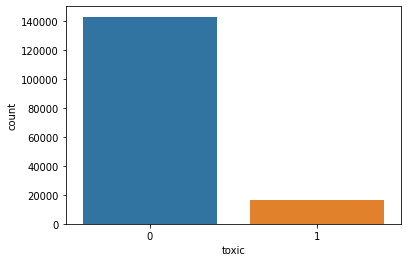

In [5]:
sns.countplot(data=toxic, x='toxic')

Присутствует дисбаланс классов.

In [6]:
toxic.query('toxic == 1')['toxic'].count()

16186

### Очистка

In [7]:
# оставляем только символы Латинского алфавита
# приврдим к нижнему регистру
def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text.lower()).split())

In [8]:
toxic['clear_text'] = toxic['text'].apply(clear_text)
toxic.head()

,Unnamed: 0,text,toxic,clear_text
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that s on


### Токенизация и лемматизация

In [9]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
def lemmatize(text):
    lemm = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    return " ".join([lemm.lemmatize(token, get_wordnet_pos(token)) for token in tokens])

toxic['lemm_text'] = toxic['clear_text'].apply(lemmatize)

In [13]:
toxic.head()

,Unnamed: 0,text,toxic,clear_text,lemm_text
0,0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,explanation why the edits make under my username hardcore metallica fan be revert they weren t vandalism just closure on some gas after i vote at new york doll fac and please don t remove the template from the talk page since i m retire now
1,1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,d aww he match this background colour i m seemingly stuck with thanks talk january utc
2,2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,hey man i m really not try to edit war it s just that this guy be constantly remove relevant information and talk to me through edits instead of my talk page he seem to care more about the format than the actual info
3,3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,more i can t make any real suggestions on improvement i wondered if the section statistics should be later on or a subsection of types of accidents i think the references may need tidying so that they are all in the exact same format ie date format etc i can do that later on if no one else does first if you have any preferences for formatting style on references or want to do it yourself please let me know there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up it s listed in the relevant form eg wikipedia good article nominations transport,more i can t make any real suggestion on improvement i wonder if the section statistic should be later on or a subsection of type of accident i think the reference may need tidy so that they be all in the exact same format ie date format etc i can do that later on if no one else do first if you have any preference for format style on reference or want to do it yourself please let me know there appear to be a backlog on article for review so i guess there may be a delay until a reviewer turn up it s list in the relevant form eg wikipedia good article nomination transport
4,4,"You, sir, are my hero. Any chance you remember what page that's on?",0,you sir are my hero any chance you remember what page that s on,you sir be my hero any chance you remember what page that s on


## Обучение

In [14]:
# тренировочная и тестовая выборки
X_train, X_test, y_train, y_test = train_test_split(
    toxic['lemm_text'], 
    toxic['toxic'],
    test_size=0.25,
    random_state=RANDOM_STATE, 
    stratify=toxic['toxic']
)

# размеры выборок
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((119469,), (39823,), (119469,), (39823,))

In [15]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(stop_words='english')),
    ('models', LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [34]:
param = [
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', solver='liblinear')],
        'models__penalty': ['l1', 'l2'],
        'models__C': np.array([1, 2])
    },
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')]
    }
]

In [35]:
# вывод лучшей модели, ее гиперпараметры и значение метрики
rs = RandomizedSearchCV(
    pipe,
    param, 
    cv=3,
    scoring='f1',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rs.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', rs.best_score_)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Лучшая модель и её параметры:

 Pipeline(steps=[('vectorizer', TfidfVectorizer(stop_words='english')),
                ('models',
                 LogisticRegression(C=2, class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])
Метрика лучшей модели на кросс-валидации: 0.7524941648617264


In [36]:
display(pd.DataFrame(rs.cv_results_).sort_values(by='rank_test_score'))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models__penalty,param_models__C,param_models,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
2,5.520107,2.429238,1.479355,0.017977,l1,2,"LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42,\n solver='liblinear')","{'models__penalty': 'l1', 'models__C': 2, 'models': LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear')}",0.755992,0.754519,0.746972,0.752494,0.003951,1
3,13.253654,0.423969,1.577440,0.010692,l2,2,"LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42,\n solver='liblinear')","{'models__penalty': 'l2', 'models__C': 2, 'models': LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear')}",0.755403,0.752283,0.745661,0.751116,0.004062,2
0,3.488355,0.005073,1.411895,0.008219,l1,1,"LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42,\n solver='liblinear')","{'models__penalty': 'l1', 'models__C': 1, 'models': LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear')}",0.745356,0.745437,0.739295,0.743363,0.002877,3
1,11.010849,0.212709,1.586031,0.052611,l2,1,"LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42,\n solver='liblinear')","{'models__penalty': 'l2', 'models__C': 1, 'models': LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear')}",0.746042,0.740854,0.739088,0.741994,0.002952,4
4,228.084542,5.287665,5.183600,0.060928,NaN,NaN,"RandomForestClassifier(class_weight='balanced', random_state=42)","{'models': RandomForestClassifier(class_weight='balanced', random_state=42)}",0.644722,0.651768,0.639047,0.645179,0.005203,5


In [37]:
# метрика на тестовой выборке
print(f'Метрика F1 на тестовой выборке: {round(f1_score(y_test, rs.predict(X_test)), 2)}')

Метрика F1 на тестовой выборке: 0.75


Лучшая модель по результатам RandomizedSearch - LogisticRegression c параметрами C=2, class_weight='balanced', penalty='l1', random_state=42,solver='liblinear'. На тестовой выборке значение метрики f1 = 0.75

## Выводы

- В представленном наборе данных 159292 уникальных комметариев пользователей, каждый из которых классифицирован на негативное и позитивное. Присутствует дисбаланс классов
- Для дальнейшего обучения моделей для текстовых данных проведены следующие преобразования:
  - очистка (оставлены только латинские буквы, приведенные к нижнему регистру), 
  - токенизация (разбиение текста на токены: отдельные фразы, слова, символы. В данном случае, токен - одно слово), 
  - лемматизация (слова приведены к начальной форме),
  - векторизация (извлечения признаков из текстовых данных, путем вычисления важности каждого слова в документе относительно количества его употреблений в данном документе и во всей коллекции текстов, при этом позволяя выделить ключевые слова и понять, какие слова имеют больший вес для определенного документа в контексте всей коллекции)
- Для обучения были выбраны модели: 
  - LogisticRegression(C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear'),
  - LogisticRegression(C=2, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear'),
  - LogisticRegression(C=1, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear'),
  - LogisticRegression(C=1, class_weight='balanced', penalty='l2', random_state=42, solver='liblinear'),
  - RandomForestClassifier(class_weight='balanced', random_state=42)
- В каждой модели установлен параметр class_weight='balanced' для учета дисбаланса классов
- По значениям метрики f1 была выбрана лучшая модель -  LogisticRegression c параметрами C=2, class_weight='balanced', penalty='l1', random_state=42, solver='liblinear'
- На тестовой выборке значение метрики f1 = 0.75